# Object Detection from Sentinel 1 Preprocessed scene

This code runs an object detection over a preprocessed subset of a Sentinel-1 scene (i.e. GRDH IW, orbit file, calibration, terrain correction, convert to dB) and extracts 75x75 pixel subsets around each indiviual object to feed these into our ship-iceberg-classification model. 

The testscene i have used is S1B_IW_GRDH_1SDH_20200730T100802_20200730T100827_022699_02B151_F93E. It shows a part of the Illuissat fjord in Greenland. I suspect that virtually all floating objects are icebergs, but it is a nice scene because the density of floating objects is quite high. The processed version is uploaded into the drive.

Unfortunatly, i did not managed to get this code to work with one of our models so far. Downloading the model to my local machine and loading it into my own Python environment didn't worked, because out model requires a GPU if i understand correctly. If I tried to run this code in the Colab and import the S1-scene from my Drive, it crashes when reading the variables of the nc-Dataset. I read that this may be because of RAM limitations, but I'm not sure on that, because it also crashes if my S1-subset is only 1000x1000 pixels. Maybe it's easier to import pictures (.png) for the different bands instead of an .nc file.

Until this is solved, this is just a demo. I imitated the output of the model with a random number in the last part of the code to show how it may look like in the end.

Further things to be done:
1. Get this code running with our model.
2. Check how the model performs if the extracted 75x75 subset  contains multiple objects. If it performs poorly, try to "shift" the subset, so that it only contains one object.
3. Add class labels, probabilities of prediction and legend to the last plot.

Import the required libraries

In [41]:
import xarray as xr

# import utm
import numpy as np
import os
import skimage.measure as measure
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import tensorflow as tf
# from google.colab import drive
import random

Create a function for the Lee filter, which will later be used to reduce spackle noise. From here: https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python

In [42]:
def lee_filter(img, size):
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

Mount the Google drive and import our model.

In [44]:
# drive.mount('/content/drive')

# model = tf.keras.models.load_model('/content/drive/My Drive/Iceberg_Ship_Classification/my_model.hd5')

# ds = xr.open_dataset("/content/drive/My Drive/Iceberg_Ship_Classification/S1B_IW_GRDH_1SDH_20200730T100802_20200730T100827_022699_02B151_F93E_cal_ter_db_UTM_msk_subset.nc")
# print("import finished")

Set working directory and import the preprocessed Sentinel-1 scene. 

In [47]:
wdir = "H:/Eigene Dateien/Studium/9. Semester/ML_with_TensorFlow/Project/Data/Testscenes/"
os.chdir(wdir)

ds = xr.open_dataset("./Output/S1B_IW_GRDH_1SDH_20200730T100802_20200730T100827_022699_02B151_F93E_cal_ter_db_UTM_msk.nc")

Next, get the HH and HV band from the scene. To keep it simple, I will only use a 1000x1000 pixel subset of this scene. From the HH and HV bands we can calculate the total backscatter in a third band.

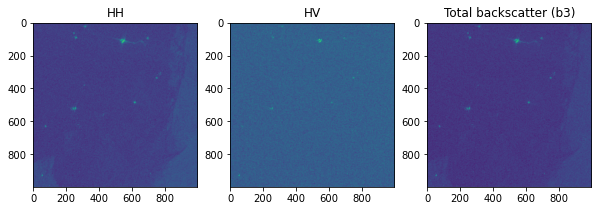

In [48]:
hh = np.array(ds["Sigma0_HH_db"][2000:3000,6000:7000])
hv = np.array(ds["Sigma0_HV_db"][2000:3000,6000:7000])

b3 = hh + hv

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,10))
hh_p = ax1.imshow(hh)
ax1.set_title("HH")
hv_p = ax2.imshow(hv)
ax2.set_title("HV")
b3_p = ax3.imshow(b3)
ax3.set_title("Total backscatter (b3)")
#fig.colorbar(hh_p, ax=ax1)
#fig.colorbar(hv_p, ax=ax2)
plt.show()

To reduce the speckle noise, apply our Lee filter and plot the output.

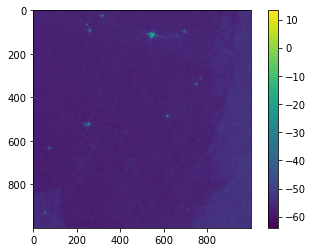

In [49]:
hh = lee_filter(hh, 20)
hv = lee_filter(hv, 20)
b3 = lee_filter(b3, 20)

plt.imshow(b3)
plt.colorbar()
plt.show()

Some bright objects are in the subset of the scene, most likely icebergs. To extract their position, I will calculate a threshold based on the median and the standard deviation fo the total backscatter. This is super simple but works quite well for this subset. I'm not sure how it will perform in other scenes (different inclination angles, rougher seas etc.), so we may think of something else.

In [50]:
thresh = np.nanmedian(b3) + 4*np.std(b3)
print(thresh)

-48.10542106628418


All pixels above this threshold are considered to be bight and are likely ships or icebergs.

To extract the locations of the different objects and place a bounding box around them, I create an array with zeros (boring water) and ones (detected object).

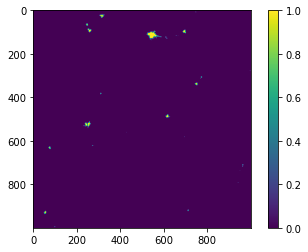

In [51]:
# Create array of zeros
roi = np.zeros(np.shape(b3))
# Mark all potential objects with ones
roi[b3>thresh] = 1

plt.imshow(roi)
plt.colorbar()
plt.show()

The bright objects visible in the total backscatter plot have been succesfully detected.

Several very small objects consisting of just one or two pixels were detected, because the total backscatter of these pixels were above our threshold. These pixels are very likely no real objects but image noise. To get rid of them, a unique value is assigned to each area of pixels with the same value. Then, all very small areas are removed from our list of potential objects. Finally, we can get the bounding boxes of the detected objects.

Number of potential objects before removing small ones: 56

Number of potential objects after removing small ones: 24


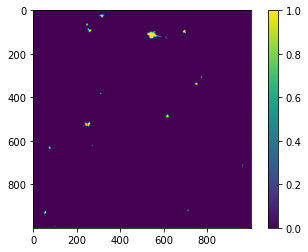

In [52]:
# Assign unique value for each region of same values
roi_labeled = measure.label(roi, connectivity=2)
print("Number of potential objects before removing small ones: " + str(np.max(roi_labeled)))

# Count occurences of unique values
unique, counts = np.unique(roi_labeled, return_counts=True)

# Get index of all regions consisting of less then 5 pixels 
# np where returns a tuple of an np.array, [0] at end gets only the np.array
idx = np.where(counts<5)[0]

# Assign 0 to all pixels in the roi-mask that are only small regions
for i in idx:
    roi[roi_labeled==i] = 0
    
# Assign unique value for each region of same values again, now without the small regions
roi_labeled = measure.label(roi, connectivity=2)
print("\nNumber of potential objects after removing small ones: " + str(np.max(roi_labeled)))
plt.imshow(roi)
plt.colorbar()
plt.show()

# Get bboxes of each region    
bboxes = [area.bbox for area in measure.regionprops(roi_labeled)]

Prepare python lists for our output.

In [54]:
ships        = []
ships_geo    = []
icebergs     = []
icebergs_geo = []
ufo          = []
ufo_geo      = []

Prepare a plot that shows our objects with a different coloured bounding box, depending on the object type. Then, iterate through all the obects, create a 75x75 subset with each object in the center. This subset is then fed into our model and the result is stored in the python lists.

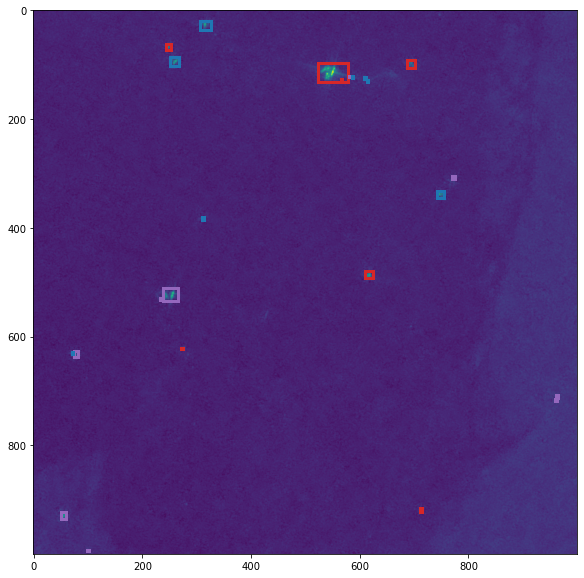

In [60]:
# Linewidth for Plot
lw = 3

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(b3)


for bbox in bboxes:
    # Calculate the extend of bbox
    height = bbox[2]-bbox[0]
    width = bbox[3]-bbox[1]
    # coordinates of upper left pexel of bbox (can be used for plotting)
    ul = [bbox[1], bbox[0]]
    
    # Calculate center of bbox
    c_x = (bbox[0]+bbox[2])/2
    c_y = (bbox[1]+bbox[3])/2
    roi_center = [c_x, c_y]

    # Define extend of 75*75 subset with center of bbox in the middle
    # a = sub_roi
    x1 = round(roi_center[0])-38
    x2 = round(roi_center[0])+37
    y1 = round(roi_center[1])-38
    y2 = round(roi_center[1])+37
    
    # If parts of the subset would be out of bounds of original image, place the subplot at the border of the image
    if x1 < 0:
        x1 = 0
        x2 = 75
    if y1 < 0:
        y1 = 0
        y2 = 75
    
    if x2 > np.shape(b3)[0]:
        x1 = np.shape(b3)[0]-76
        x2 = np.shape(b3)[0]-1
        
    if y2 > np.shape(b3)[1]:
        y1 = np.shape(b3)[1]-76
        y2 = np.shape(b3)[1]-1        
    

    sub_hh = hh[x1:x2, y1:y2]
    sub_hv = hv[x1:x2, y1:y2]
    sub_b3 = b3[x1:x2, y1:y2]
    

    sub_img = np.dstack((sub_hh, sub_hv, sub_b3))

    
    # feed sub_img into the model to predict
    
    # Output temporarily imitated by a random number
    output = random.uniform(0,1)
    
    if output < 0.3:
        # Ship!
        ships.append(bbox)
        #ships_geo.append([LatLon_from_XY(product, bbox[0], bbox[1]), 
        #                  LatLon_from_XY(product, bbox[2], bbox[3])])
        box = mpatches.Rectangle((ul[0], ul[1]), width, height, 
                                 edgecolor='tab:red', linewidth=lw, fill=None)
    elif output > 0.7:
        # Iceberg!
        icebergs.append(bbox)
        #icebergs_geo.append([LatLon_from_XY(product, bbox[0], bbox[1]), 
        #                     LatLon_from_XY(product, bbox[2], bbox[3])])
        box = mpatches.Rectangle((ul[0], ul[1]), width, height, 
                                 edgecolor='tab:blue', linewidth=lw, fill=None)
    else:
        # Unknown floating object
        ufo.append(bbox)
        #ufo_geo.append([LatLon_from_XY(product, bbox[0], bbox[1]), 
        #                LatLon_from_XY(product, bbox[2], bbox[3])])
        box = mpatches.Rectangle((ul[0], ul[1]), width, height, 
                                 edgecolor='tab:purple', linewidth=lw, fill=None)
    
    ax.add_patch(box)
plt.show()



In theory, red boxes show ships, blue ones icebergs and purple ones UFOs (i.e. low probability for any class). Since I have imitated model outputs with random numbers, they doesn't mean anything here but proof the concept (at least I hope so ;) ).